<h1>One Generator to beat 'em Two</h1>

An attempt to create a generator that will try to beat two discriminators: One that discriminates between real and fake anime faces and the other that does the same but for human faces. The most important problem is going to make the generator strong enough.

### Things to test

* The `stats` variable for both human and anime.
* Different transformations for both anime and human.
* ResNet-y model for GAN
* Two side-by-side architectures: One based on `ConvTranspose2d` and the other `Upsample`, and then summing them up.

# Setting Up Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Importing Libraries

In [2]:
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset

from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torchvision.transforms import Compose
from torchvision import transforms
from torchvision.utils import save_image

import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from glob import glob
import imageio

# Global Variables

In [22]:
BATCH_SIZE = 128
IMAGES_TO_USE = 63565
IMG_SIZE = 64
NUM_WORKERS = 2
STARTING_INDEX = 0

MODELS_PATH = "/content/drive/MyDrive/Jovian Project/Models"
GENERATED_IMAGES_PATH = "/content/drive/MyDrive/Jovian Project/Generated"
ANIME_FACES_DATASET_PATH = "/content/drive/MyDrive/Jovian Project/Datasets/Anime Faces/animefacedataset"
HUMAN_FACES_DATASET_PATH = "/content/drive/MyDrive/Jovian Project/Datasets/Human Faces/ffhq-face-data-set/thumbnails128x128"

# Utility Functions

Some utility functions created for tasks like displaying images, shifting tensors to device etc.

In [4]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [5]:
def denorm(img):
  stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
  return img * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
  fig, ax = plt.subplots(figsize=(8, 8))
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

In [6]:
def save_samples(index, generator, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(GENERATED_IMAGES_PATH, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [7]:
def save_model(model, model_name):
  allowed_models = ["generator.pth", "discriminator_anime.pth", "discriminator_human.pth"]
  if model_name not in allowed_models:
    print("Invalid Model Name")
    return
  else:
    print("Saving ", model_name)
    torch.save(model.state_dict(), os.path.join(MODELS_PATH, model_name))

# Preparing DataLoader

The DataLoader will give two batches: One of anime faces, and the other of human faces.

## Dataset Module

In [8]:
class ImageDataset(Dataset):
  def __init__(self, dataset_path, transform=None):
    imageFiles = glob(dataset_path)[:IMAGES_TO_USE]
    
    self.images = imageFiles
    self.transform = transform
  
  def __getitem__(self, index):
    img = Image.open(self.images[index])

    if self.transform is not None:
      img = self.transform(img) 

    return img
  
  def __len__(self):
    return len(self.images)

  def size(self, _):
    return len(self.images)

In [9]:
# ax = plt.imshow(AnimeDataset()[2])
# ax.axes.get_xaxis().set_ticks([])
# ax.axes.get_yaxis().set_ticks([])
# plt.show()

## Preparing DataLoaders

In [10]:
def Loader():
  stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

  transformations = Compose([
      transforms.Resize(size=IMG_SIZE),
      transforms.CenterCrop(size=IMG_SIZE),
      transforms.ToTensor(),
      transforms.Normalize(*stats)
    ])

  anime_dataset = ImageFolder(ANIME_FACES_DATASET_PATH, transform=transformations)
  human_dataset = ImageFolder(HUMAN_FACES_DATASET_PATH, transform=transformations)

  anime_loader = DataLoader(anime_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
  human_loader = DataLoader(human_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)

  return anime_loader, human_loader

def GetSingleBatch(loader):
  for anime, human in loader:
    return anime, human

In [11]:
loader = Loader()

FileNotFoundError: ignored

In [ ]:
anime_loader, human_loader = loader

In [ ]:
anime, _ = GetSingleBatch(anime_loader)
human, _ = GetSingleBatch(human_loader)

In [ ]:
for (a, _), (c, _) in zip(anime_loader, human_loader):
  show_images(a)
  show_images(c)
  break

# Discriminator 

In [12]:
class Discriminator(nn.Module):
  def __init__(self):                   # 128 x 3 x 64 x 64
    super().__init__()
    self.block_1 = self.block(3, 64)    # 128 x 64 x 32 x 32
    self.block_2 = self.block(64, 128)  # 128 x 128 x 16 x 16
    self.block_3 = self.block(128, 256) # 128 x 256 x 8 x 8
    self.block_4 = self.block(256, 512) # 128 x 512 x 4 x 4
    self.block_5 = self.block(512, 1)   # 128 x 1 x 2 x 2

    self.flatten = nn.Flatten()         # 128 x 4
    self.linear = nn.Linear(4, 1)       # 128 x 1
    self.relu = nn.ReLU(inplace=True)   # 128 x 1
    self.sigmoid = nn.Sigmoid()         # 128 x 1

  def forward(self, inputs):
    inputs = self.block_1(inputs)
    inputs = self.block_2(inputs)
    inputs = self.block_3(inputs)
    inputs = self.block_4(inputs)
    inputs = self.block_5(inputs)

    inputs = self.flatten(inputs)
    inputs = self.linear(inputs)
    inputs = self.relu(inputs)
    inputs = self.sigmoid(inputs)

    return inputs

  def block(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1):
    layers = [
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
        nn.LeakyReLU(0.2, inplace=True),
        nn.BatchNorm2d(out_channels),
    ]
    return nn.Sequential(*layers)

# Generator

In [13]:
class Generator(nn.Module):
  def __init__(self):
    super().__init__()                                                            # 128 x 128 x 1 x 1
    
    self.block_1 = self.block(128, 512, kernel_size=4, stride=1, padding=0)       # 128 x 512 x 1 x 1
    self.block_2 = self.block(512, 256)                                           # 128 x 256 x 2 x 2
    
    self.res_1 = nn.Sequential(
        self.block(256, 256, kernel_size=1, stride=1, padding=0),
        self.block(256, 256, kernel_size=1, stride=1, padding=0)
    )                                                                             # 128 x 256 x 2 x 2
    
    self.block_3 = self.block(256, 128)                                           # 128 x 128 x 4 x 4
    self.block_4 = self.block(128, 64)                                            # 128 x 64 x 8 x 8

    self.res_2 = nn.Sequential(
        self.block(64, 64, kernel_size=1, stride=1, padding=0),
        self.block(64, 64, kernel_size=1, stride=1, padding=0),
    )

    self.output = self.block(64, 3)


  def forward(self, inputs):
    inputs = self.block_1(inputs)
    inputs = self.block_2(inputs)
    
    inputs = self.res_1(inputs) + inputs

    inputs = self.block_3(inputs)
    inputs = self.block_4(inputs)

    inputs = self.res_2(inputs) + inputs
    inputs = self.output(inputs)

    return inputs

  def block(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1):
    layers = [
        nn.ConvTranspose2d(in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(out_channels),
    ]
    return nn.Sequential(*layers)

In [14]:
xb = torch.randn(128, 128, 1, 1)
xb.shape

torch.Size([128, 128, 1, 1])

In [15]:
gen = Generator()

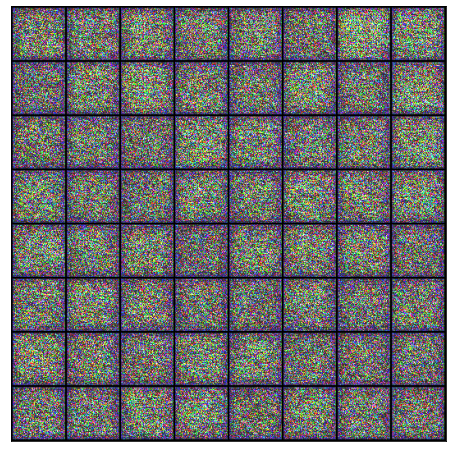

In [16]:
show_images(gen(xb))

# Discriminator Training

In [18]:
def training_discriminator(discriminator, generator, real_images, fixed_latent, optimizer_discriminator, device):
  optimizer_discriminator.zero_grad()

  real_predictions = discriminator(real_images)
  real_targets = torch.ones(BATCH_SIZE, 1, device=device)
  real_loss = F.binary_cross_entropy(real_predictions, real_targets)
  real_score = real_predictions.mean().item()

  fake_images = generator(fixed_latent)

  fake_predictions = discriminator(fake_images)
  fake_targets = torch.zeros(BATCH_SIZE, 1, device=device)
  fake_loss = F.binary_cross_entropy(fake_predictions, fake_targets)
  fake_score = fake_predictions.mean().item()

  loss = real_loss + fake_loss

  loss.backward()
  optimizer_discriminator.step()

  return loss.item(), fake_loss, real_loss

# Generator Training

In [19]:
def training_generator(generator, discriminator_1, discriminator_2, fixed_latent, optimizer_generator, scheduler, device, grad_clip=None):
  fake_images = generator(fixed_latent)

  discriminator_1_predictions = discriminator_1(fake_images)
  discriminator_2_predictions = discriminator_2(fake_images)

  targets_1 = torch.ones(BATCH_SIZE, 1, device=device)
  targets_2 = torch.ones(BATCH_SIZE, 1, device=device)

  loss_1 = F.binary_cross_entropy(discriminator_1_predictions, targets_1)
  loss_2 = F.binary_cross_entropy(discriminator_2_predictions, targets_2)

  loss = loss_1 + loss_2
  loss.backward()

  if grad_clip is not None:
    nn.utils.clip_grad_value_(generator.parameters(), grad_clip)

  optimizer_generator.step()
  optimizer_generator.zero_grad()
  scheduler.step()

  return loss.item()

# GAN Training Loop

In [25]:
def training_loop(retrain=False):
  device = get_default_device()
  print("Device: ", device)

  generator = Generator()

  discriminator_anime = Discriminator()
  discriminator_human = Discriminator()

  if retrain == True:
    generator.load_state_dict(torch.load(os.path.join(MODELS_PATH, "generator.pth")))
    discriminator_anime.load_state_dict(torch.load(os.path.join(MODELS_PATH, "discriminator_anime.pth")))
    discriminator_human.load_state_dict(torch.load(os.path.join(MODELS_PATH, "discriminator_human.pth")))

  generator = to_device(generator, device)
  discriminator_anime = to_device(discriminator_anime, device)
  discriminator_human = to_device(discriminator_human, device)

  # save_model(discriminator_anime, "discriminator_anime.pth")

  anime_loader, human_loader = Loader()
  anime_loader = DeviceDataLoader(anime_loader, device)
  human_loader = DeviceDataLoader(human_loader, device)

  print(len(anime_loader))

  fixed_latent = torch.randn(BATCH_SIZE, 128, 1, 1, device=device)

  def fit(epochs, max_lr, lr, weight_decay=0, grad_clip=None):
    torch.cuda.empty_cache()

    optimizer_generator = torch.optim.Adam(generator.parameters(), lr=max_lr, weight_decay=weight_decay, betas=(0.5, 0.999))
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer_generator, max_lr, epochs=epochs, steps_per_epoch=len(anime_loader))

    optimizer_discriminator_anime = torch.optim.Adam(discriminator_anime.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizer_discriminator_human = torch.optim.Adam(discriminator_human.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
      for (anime, _), (human, _) in tqdm(zip(anime_loader, human_loader)):
        loss_anime, score_anime, score_generator_anime = training_discriminator(discriminator_anime, generator, anime, fixed_latent, optimizer_discriminator_anime, device)
        loss_human, score_human, score_generator_human = training_discriminator(discriminator_human, generator, human, fixed_latent, optimizer_discriminator_human, device)

        loss_generator = training_generator(generator, discriminator_anime, discriminator_human, fixed_latent, optimizer_generator, scheduler, device, grad_clip=grad_clip)
        
      print(f"Epoch: {epoch}")
      print(f"Discriminator Anime Loss: {loss_anime} | Discirminator Anime Score: {score_anime} | Generator Score From Anime: {score_generator_anime}")
      print(f"Discriminator Human Loss: {loss_human} | Discriminator Human Score: {score_human} | Generator Score From Human: {score_generator_human}")
      print(f"Generator Loss: {loss_generator}\n")
      
      save_samples(epoch+STARTING_INDEX, generator, fixed_latent, show=False)
  
  def save_all_models():
    print("\n\nSaving All Models")
    save_model(generator, "generator.pth")
    save_model(discriminator_anime, "discriminator_anime.pth")
    save_model(discriminator_human, "discriminator_human.pth")
    print("\n")

  fit(1, 0.003, 0.001, 1e-4, 0.01)
  save_all_models()

In [26]:
training_loop()

Device:  cuda


OSError: ignored